## Imports & Data (run this at start)

In [1]:
import re
import os
from tqdm import tqdm
from datasets import load_dataset

from PIL import Image
from transformers.image_utils import load_image
import matplotlib.pyplot as plt
import numpy as np

import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, BitsAndBytesConfig, Trainer, TrainingArguments
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model, PeftModel

c:\Users\bhara\miniconda3\envs\snowflakes\lib\site-packages\onnxscript\converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\bhara\miniconda3\envs\snowflakes\lib\site-packages\onnxscript\converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [2]:
data_files = {"train": "train.jsonl", "dev": "dev.jsonl", "test": "test.jsonl"}
dataset = load_dataset("cambridgeltl/vsr_random", data_files=data_files)

train_ds = dataset["train"]
test_ds = dataset["test"]
val_ds = dataset["dev"]

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "HuggingFaceTB/SmolVLM-Instruct"

## Testing out performance pre fine-tuning

First we load a sample image from the data and plot it.

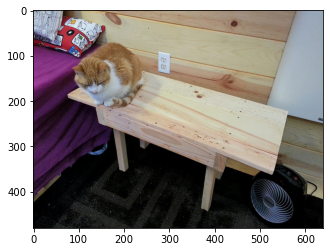

In [4]:
img_path = os.path.join("visual-spatial-reasoning/images", train_ds[2]["image"])
img = load_image(img_path)
plt.imshow(img)

We can also see what the caption and label for this is

In [5]:
caption = train_ds[2]["caption"]
label = train_ds[2]["label"]
relation = train_ds[2]["relation"]

print(caption)
print(label)
print(relation)

The bed is right of the bench.
1
right of


Now let's load the SmolVLM-Instruct model, which is the Base model finetuned for handling structured prompts/questions.

In [17]:
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(model_id,
                                                torch_dtype=torch.bfloat16,
                                                _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager").to(DEVICE)

model.eval()

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionFlashAttention2(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Line

In [18]:
def run_inference(img_path, caption):
  # Load images
  img = load_image(img_path)
 
  # Create input messages
  messages = [
      {
          "role": "user",
          "content": [
              {"type": "image"},
              {"type": "text", "text": f"{caption.rstrip('.')}, true or false?"}
          ]
      },
  ]

  # Prepare inputs
  prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
  inputs = processor(text=prompt, images=[img], return_tensors="pt")
  inputs = inputs.to(DEVICE)

  # Generate outputs
  with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=500)
  generated_texts = processor.batch_decode(
      generated_ids,
      skip_special_tokens=True,
  )

  return generated_texts[0]

output = run_inference(img_path, caption)

print(output)

User:<image>The bed is right of the bench, true or false?
Assistant: True.


In this case, the model predicts correctly, since the bed is on the right side of the bench (from the perspective of the bench). Checkout line 3 of visual-spatial-reasoning/data/split/random/train.jsonl for the ground truth label (its 1 for true).

## Prelim Run on Test Set

In [19]:
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(model_id,
                                                torch_dtype=torch.bfloat16,
                                                _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager").to(DEVICE)
model.eval()

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionFlashAttention2(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Line

In [20]:
# Regular expression pattern to extract assistant response
answer_pattern = re.compile(r"Assistant:\s*(\w+)")

correct = 0
preds = []
total = len(test_ds)

# Function to process each entry
def evaluate(entry):
    global correct
    global preds
    img_path = os.path.join("visual-spatial-reasoning/images", entry["image"])

    output = run_inference(img_path, entry["caption"])

    match = answer_pattern.search(output)
    answer = match.group(1) if match else None

    if answer == "True":
      preds.append(1)
    else:
      preds.append(0)

    # Validate answer
    if answer in {"True", "False"} and (answer == "True") == (entry["label"] == 1):
        correct += 1

# Process dataset with tqdm for progress tracking
for entry in tqdm(test_ds, desc="Processing images"):
    evaluate(entry)

# save preds
with open("preds.txt", "w") as f:
    for i in range(len(preds)):
        f.write(str(preds[i])+"\n")

# Print results
print(f"Total images: {total}")
print(f"Correct: {correct} ({correct / total:.2%} accuracy)")

Processing images: 100%|██████████| 2195/2195 [13:47<00:00,  2.65it/s]

Total images: 2195
Correct: 1469 (66.92% accuracy)


You should get an accuracy of 66%. Not terrible, but def below human performance of 95%

## Training

A lot of this is taken straight from the following notebook: https://github.com/huggingface/smollm/blob/main/vision/finetuning/Smol_VLM_FT.ipynb

In this case we are fine-tuning the instruct model rather than base since we want it to be able to answer spatial queries in a Q&A format which Instruct has already been made for.

In [23]:
# If you want to deploy the model, you should not quantize to 4bits since converting to onnx not supported

USE_QLORA = False

processor = AutoProcessor.from_pretrained(model_id)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=False if USE_QLORA else True,
    init_lora_weights="gaussian"
)

lora_config.inference_mode = False

if USE_QLORA:

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForVision2Seq.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        _attn_implementation="flash_attention_2"
    ).to(DEVICE)

else:

    model = AutoModelForVision2Seq.from_pretrained(
        model_id,
        torch_dtype = torch.bfloat16,
        _attn_implementation="flash_attention_2"
    ).to(DEVICE)

model.add_adapter(lora_config)
model.enable_adapters()

if USE_QLORA:
    model = prepare_model_for_kbit_training(model)
    
model = get_peft_model(model, lora_config)

print(model.get_nb_trainable_parameters())

(11269248, 2257542128)


The number of trainable params is 11,269,248 so about 11M. Since we are using bfloat16, this space the trainable params take up is only 11M * (16/8) bytes, so about 22MB

The collate function is pretty important when you work with batch training. It defines the structure of your prompts and how to combine them for batch processing.

In [24]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
    
  texts = []
  images = []

  for example in examples:

      image_path = os.path.join("visual-spatial-reasoning/images", example["image"])

      if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

      image = load_image(image_path)

      if image.mode != 'RGB':
        image = image.convert('RGB')

      caption = example["caption"]
      label = "True." if example["label"] == 1 else "False."

      messages = [
          {
              "role": "user",
              "content": [
                  {"type": "image"},
                  {"type": "text", "text": f"{caption.rstrip('.')}, true or false?"}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": label}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)

      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

In [25]:
len(train_ds)

7680

In [28]:
model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=1,
    optim="paged_adamw_8bit" if USE_QLORA else "adamw_hf", # for 8-bit, keep this, else adamw_hf
    bf16=True, # underlying precision for 8bit
    output_dir=f"./{model_name}-vsr",
    hub_model_id=f"{model_name}-vsr",
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
)

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Now we can train! On a single A100, this took me about 2.5 hours

In [29]:
trainer.train()

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
25,0.594000
50,0.115700
75,0.059900
100,0.053000
125,0.050300
150,0.047300
175,0.046600
200,0.047300
225,0.044800
250,0.042900


TrainOutput(global_step=480, training_loss=0.07744303178042174, metrics={'train_runtime': 9619.0, 'train_samples_per_second': 0.798, 'train_steps_per_second': 0.05, 'total_flos': 1.3675982181090816e+17, 'train_loss': 0.07744303178042174, 'epoch': 1.0})

The final output model params should be saved in the directory SmolVLM-Instruct-vsr/checkpoint-480

## Load & Re-Test

In [31]:
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager"
)

model = PeftModel.from_pretrained(model, "SmolVLM-Instruct-vsr/checkpoint-480")
model = model.merge_and_unload()
model = model.to(torch.bfloat16).to(DEVICE)
model.eval()

processor = AutoProcessor.from_pretrained(model_id)

In [32]:
correct = 0
preds = []
total = len(test_ds)

# Process dataset with tqdm for progress tracking
for entry in tqdm(test_ds, desc="Processing images"):
    evaluate(entry)

# save preds
with open("preds_post.txt", "w") as f:
    for i in range(len(preds)):
        f.write(str(preds[i])+"\n")

# Print results
print(f"Total images: {total}")
print(f"Correct: {correct} ({correct / total:.2%} accuracy)")

Processing images: 100%|██████████| 2195/2195 [12:40<00:00,  2.89it/s]

Total images: 2195
Correct: 1661 (75.67% accuracy)


Got a 10% accuracy improvement from 66% to 76% on the test set after fine-tuning, nice!
We did LoRA training and only for a single epoch, this is decent! More epochs would improve even more, and using regular training instead of LoRa would also likely improve, although the training time would increase accordingly.

## Export for Deployment

In [3]:
# Load images
image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

# Initialize processor and model
processor = AutoProcessor.from_pretrained(model_id)

# Create input messages
messages1 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "The statue is away from the city, true or false?"}
        ]
    },
]

messages2 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "The statue is in the city, true or false?"}
        ]
    },
]

messages3 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "How would you describe the spatial relationship between the statue and the city?"}
        ]
    },
]

# Prepare inputs
prompt1 = processor.apply_chat_template(messages1, add_generation_prompt=True)
input1 = processor(text=prompt1, images=[image1], return_tensors="pt")

# Prepare inputs
prompt2 = processor.apply_chat_template(messages2, add_generation_prompt=True)
input2 = processor(text=prompt2, images=[image1], return_tensors="pt")

# Prepare inputs
prompt3 = processor.apply_chat_template(messages3, add_generation_prompt=True)
input3 = processor(text=prompt3, images=[image1], return_tensors="pt")

inputs = [input1, input2, input3]


Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [4]:
import torch
from transformers import AutoModelForVision2Seq, BitsAndBytesConfig

# DEVICE = 'cpu'
DEVICE = 'cuda'
bitsnbytes = True

# Configure 8-bit quantization
bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
    )

# Load the model in 8-bit for CPU
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    quantization_config=bnb_config if bitsnbytes else None,
    _attn_implementation="eager",
    device_map=DEVICE,
    torch_dtype=torch.float32
)

model = PeftModel.from_pretrained(model, "checkpoint-480")
model = model.merge_and_unload()
model.eval()  # Set model to evaluation mode

c:\Users\bhara\miniconda3\envs\snowflakes\lib\site-packages\peft\tuners\lora\bnb.py:85: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear8bitLt(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear8bitLt(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear8bitLt(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear8bitLt(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
       

In [5]:
smol = 0
largebits = 0
for name, param in model.named_parameters():
    if param.dtype == torch.float32:
        largebits += 1
    elif param.dtype == torch.int8:
        smol += 1

print(smol)
print(largebits)

331
326


In [6]:
import time

def eval(input):

    input = input.to(DEVICE)
    t1 = time.perf_counter()
    generated_ids = model.generate(**input, max_new_tokens=500)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    t2 = time.perf_counter()

    print(t2-t1)
    print(generated_texts[0])

In [7]:
# Timing and eval of the non-quantized model

for input in inputs:
    eval(input)

5.808797399979085
User:<image>The statue is away from the city, true or false?
Assistant: True.
3.5453967000357807
User:<image>The statue is in the city, true or false?
Assistant: False.
2.959940499975346
User:<image>How would you describe the spatial relationship between the statue and the city?
Assistant: The city is far away from the statue.


Great! Not only is it getting the true/false questions right, but it also is able to properly describe the relationship between the city and statue. Note we didn't explicitly train for that.

In [7]:
# Timing and eval of quantized model

for input in inputs:
    eval(input)

c:\Users\bhara\miniconda3\envs\snowflakes\lib\site-packages\bitsandbytes\autograd\_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


4.67521829996258
User:<image>The statue is away from the city, true or false?
Assistant: True.
3.6447747999918647
User:<image>The statue is in the city, true or false?
Assistant: True.
4.497896099986974
User:<image>How would you describe the spatial relationship between the statue and the city?
Assistant: The city is far away from the statue.


The quantized model isn't much faster surprisingly!! And also performs worse as the second option should be False.

In [8]:
import torch.onnx

DEVICE = "cpu"

# Load Model
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    _attn_implementation="eager"
)
# model = PeftModel.from_pretrained(model, "SmolVLM-Instruct-vsr/checkpoint-480")
# model = model.merge_and_unload()
# model = model.to(torch.bfloat16)  # Keep dtype in bfloat16

# Convert to eval mode
model.eval()

tensor_inputs = {
    "pixel_values": inputs["pixel_values"].to(torch.float32),
    "pixel_attention_mask": inputs["pixel_attention_mask"].to(torch.float32),
    "input_ids": inputs["input_ids"],
    "attention_mask": inputs["attention_mask"]
}


# Dynamic axes for variable batch size and sequence length
dynamic_axes = {
    "pixel_values": {0: "batch_size", 1: "patches"},
    "pixel_attention_mask": {0: "batch_size", 1: "patches"},
    "input_ids": {0: "batch_size", 1: "sequence_length"},
    "attention_mask": {0: "batch_size", 1: "sequence_length"},
    "output": {0: "batch_size", 1: "sequence_length"}


class OnnxGenerationWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, pixel_values, pixel_attention_mask, input_ids, attention_mask):
        # Convert inputs into a dictionary mimicking BatchFeature
        batch_feature = {
            "pixel_values": pixel_values,
            "pixel_attention_mask": pixel_attention_mask,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }
        
        # Call model.generate() with the dictionary
        generated_output = self.model.generate(**batch_feature, max_new_tokens=50)
        
        return generated_output  # Must return a tensor

# Wrap the model using our generation wrapper
onnx_model = OnnxGenerationWrapper(model)


with torch.no_grad():
# Export the ONNX model
    torch.onnx.export(
        onnx_model,  # Use the wrapper
        tensor_inputs,
        "smolvlm_generate.onnx",
        input_names=["pixel_values", "pixel_attention_mask", "input_ids", "attention_mask"],
        output_names=["generated_tokens"],  # Name output properly,
        dynamic_axes=dynamic_axes,
        opset_version=17,
    )

print("ONNX model with generate() exported successfully!")
}

A failed attempt at onnx conversion. I guess VLM models aren't really supported. keep running into errors. :(